# Assigning particles unique IDs and removing particles from the simulation

For some applications, it is useful to keep track of which particle is which, and this can get jumbled up when particles are added or removed from the simulation.  It can thefore be useful for particles to have unique IDs associated with them.

Let's set up a simple simulation with 10 bodies, and give them IDs in the order we add the particles:

In [1]:
import rebound
import numpy as np

def setupSimulation(Nplanets):
    rebound.reset()
    rebound.integrator = "ias15" # IAS15 is the default integrator, so we don't need this line
    rebound.add(m=1.,ID=0)
    for i in range(1,Nbodies):
        rebound.add(m=1e-5,x=i,vy=i**(-0.5),ID=i)
    rebound.move_to_com()

Nbodies=10
setupSimulation(Nbodies)
print([rebound.particles[i].ID for i in range(rebound.N)])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


Now let's do a simple example where we do a short initial integration to isolate the particles that interest us for a longer simulation:

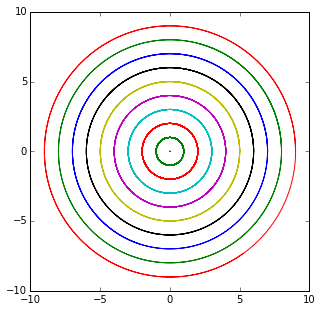

In [2]:
setupSimulation(Nbodies)
Noutputs = 1000
xs = np.zeros((Nbodies, Noutputs))
ys = np.zeros((Nbodies, Noutputs))
times = np.linspace(0.,50*2.*np.pi, Noutputs, endpoint=False)
for i, time in enumerate(times):
    rebound.integrate(time)
    xs[:,i] = [rebound.particles[j].x for j in range(Nbodies)]
    ys[:,i] = [rebound.particles[j].y for j in range(Nbodies)]
%matplotlib inline
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(15,5))
for i in range(Nbodies):
    plt.plot(xs[i,:], ys[i,:])
ax.set_aspect('equal')

At this stage, we might be interested in particles that remained within some semimajor axis range, particles that were in resonance with a particular planet, etc.  Let's imagine a simple (albeit arbitrary) case where we only want to keep particles that had $x > 0$ at the end of the preliminary integration.  For this we can use the `remove_particle` function, passing it the corresponding index in the particles array.

In [3]:
for i in reversed(range(1,Nbodies)):
    if xs[i,-1] < 0:
        rebound.remove_particle(i)
print("Number of particles after cut = {0}".format(rebound.N))
print("IDs of remaining particles = {0}".format([rebound.particles[j].ID for j in range(rebound.N)]))
print("ID\tx")
for i in range(Nbodies):
    print("{0}\t{1}".format(i, xs[i,-1]))

Number of particles after cut = 5
IDs of remaining particles = [0, 1, 4, 8, 9]
ID	x
0	6.942329259612184e-05
1	0.9540258354392658
2	-1.0427110924854333
3	-2.235604267935961
4	0.07765021611809243
5	-4.91280573550641
6	-4.876031912173703
7	-2.1809553741838963
8	2.0229880089264367
9	5.251115062189657


By default, the `remove_particle` function removes the `ith` particle from the `particles` array, and shifts all particles with higher indices down by 1.  This ensures that the original order in the `particles` array is preserved (e.g., to help with output).

By running through the planets in reverse order above, we are guaranteed that when a particle with index `i` gets removed, the particle replacing it doesn't need to also be removed (we already checked it).

If you have many particles and many removals (or you don't care about the ordering), you can save the reshuffling of all particles with higher indices with the flag `keepSorted=0`:

In [4]:
rebound.remove_particle(2, keepSorted=0)
print("Number of particles after cut = {0}".format(rebound.N))
print("IDs of remaining particles = {0}".format([rebound.particles[j].ID for j in range(rebound.N)]))

Number of particles after cut = 4
IDs of remaining particles = [0, 1, 9, 8]


We see that the `particles` array is no longer sorted by ID.  Note that the default `keepSorted=1` only *keeps* things sorted (i.e., if they were sorted by ID to start with).  If you custom-assign IDs out of order as you add particles, the default will simply preserve the original order.

You might also have been surprised that the above `rebound.remove_particle(2, keepSorted=0)` succeeded, since there was no `ID=2` left in the simulation.  That's because `remove_particle` takes the index in the particles array, so we removed the 3rd particle (with `ID=4`).  If you'd like to remove a particle by `ID`, use the `ID` keyword, e.g.

In [5]:
rebound.remove_particle(ID=9)
print("Number of particles after cut = {0}".format(rebound.N))
print("IDs of remaining particles = {0}".format([rebound.particles[j].ID for j in range(rebound.N)]))

Number of particles after cut = 3
IDs of remaining particles = [0, 1, 8]


What you'd do now depends on the application, but we can imagine cases (perhaps if we were instead writing output to a file as particles get removed) where we'd want our output arrays to remain the same size even if particles get removed from the simulation.  In this case, since the IDs are initially assigned starting from zero, we can index the output arrays using the particle IDs:

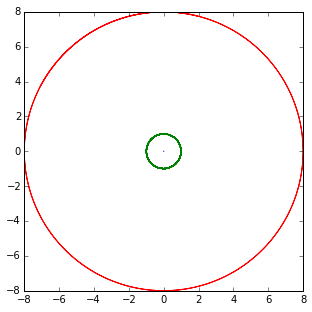

In [6]:
times = np.linspace(50*2*np.pi, 100*2*np.pi,Noutputs)
xs2 = np.zeros((Nbodies, Noutputs))
ys2 = np.zeros((Nbodies, Noutputs))
for i, time in enumerate(times):
    rebound.integrate(time)
    for j in range(rebound.N):
        xs2[rebound.particles[j].ID,i] = rebound.particles[j].x
        ys2[rebound.particles[j].ID,i] = rebound.particles[j].y
%matplotlib inline
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(15,5))
for i in range(rebound.N):
    plt.plot(xs2[rebound.particles[i].ID,:], ys2[rebound.particles[i].ID,:])
ax.set_aspect('equal')

This way, the original output arrays with all the original particles still get indexed with the particle IDs, even after everything gets reshuffled.  For example, the surviving particle with `ID=8` still corresponds to `xs2[8]` and `ys2[8]`:

In [7]:
index = 8
print("Avg orbital for particle with ID = {0} was {1}".format(index, np.mean(np.sqrt(xs2[index,::]**2 + ys2[index,::]**2))))

Avg orbital for particle with ID = 8 was 7.99587587955114
